In [1]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, multilabel_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB,ComplementNB
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from scipy.stats import chi2_contingency
from scipy.stats import chi
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import class_weight
#from sklearn.pipeline import Pipeline
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import metrics
import numpy as np
import nltk
import pandas as pd
import re

df =  pd.read_csv(r'C:\Users\Saim\Desktop\emotions.csv')
labels = df.Label.unique()

counter = Counter(df.Label)
print(counter)

df.head()

Counter({'Trust': 1159, 'Anticipation': 928, 'Sadness': 357, 'Disgust': 293, 'Joy': 279, 'Surprise': 156, 'Fear': 129, 'Anger': 85})


,No,discussion_text,Label,ModelName,TextId
0,1,...been on a low-carb diet my blood glucose h...,Trust,Emotions,508e98fc-8db4-4283-a2a4-63c3b70acf86
1,2,A major problem with the American diet is too ...,Disgust,Emotions,1349404b-4192-4da2-89ed-346d17351c6b
2,3,Everybody knows that being fat leads to Type 2...,Trust,Emotions,a8961bab-8d57-492e-89b1-07b616a605f1
3,4,For example this diet could help reduce prost...,Disgust,Emotions,10628e32-8c12-4c09-b9e0-f98885519c94
4,5,Hi everyone I have T2 diabetes and was diagnos...,Disgust,Emotions,470c5855-24b9-44b3-aedc-c5cf2ed5ed6d


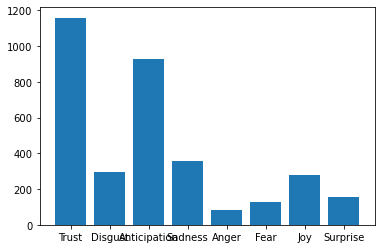

In [2]:
# Evidently dealing with imbalanced data. Lets visualize the label distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [38]:
""""This class imbalance needs to be handled in order to construct a good model"""

'"This class imbalance needs to be handled in order to construct a good model'

In [2]:
def preprocess(text):
    
    txt = re.sub(r'[-.,;:!?\'\d+]+', "", str(text).lower().strip())
    tokens = txt.split()
    
    stemmer = nltk.stem.porter.PorterStemmer()
    lst_text = [stemmer.stem(word) for word in tokens]
    
    output = " ".join(lst_text)
    return output

df["text_clean"] = df["discussion_text"].apply(lambda x: preprocess(x))
df.tail(6)["text_clean"]

3380    it depend on how you view it jenni ruhl for in...
3381    it doe have a black box warn victoza victoza t...
3382    it doe not answer the fact that my intern gluc...
3383    it doe not matter how much or what time i eat ...
3384    it doesnt includ type s of cours as well as ty...
3385    it doesnt look to me like your diabet (judg fr...
Name: text_clean, dtype: object

Text(0.5, 0, '$\\chi^2$')

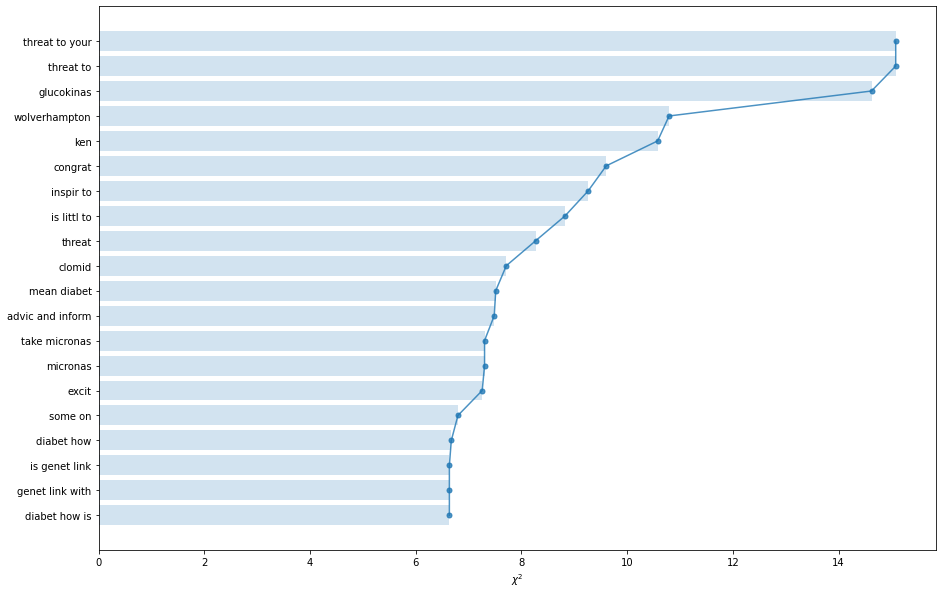

In [23]:
tvec = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))
x_train_tfidf = tvec.fit_transform(df["text_clean"])


chi2score = chi2(x_train_tfidf, df.Label)[0]

plt.figure(figsize=(15,10))

wscores = zip(tvec.get_feature_names(), chi2score)

wchi2 = sorted(wscores, key=lambda x:x[1])

topchi2 = list(zip(*wchi2[-20:]))

x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.2)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')

In [ ]:
ch2_result = []
for n in np.arange(10000,100000,10000):
    ch2 = SelectKBest(chi2, k=n)
    x_train_chi2_selected = ch2.fit_transform(x_train_tfidf, y_train)
    x_validation_chi2_selected = ch2.transform(df.Label)
    clf = LogisticRegression()
    clf.fit(x_train_chi2_selected, y_train)
    score = clf.score(x_validation_chi2_selected, y_validation)
    ch2_result.append(score)
    print "chi2 feature selection evaluation calculated for {} features".format(n)

In [83]:
vectorizer = TfidfVectorizer(stop_words = "english",
                             ngram_range = (1, 4))

corpus = df["text_clean"]
X = vectorizer.fit_transform(corpus)
vocabulary = vectorizer.vocabulary_

label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(df.Label)

In [ ]:
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95

contigency = pd.crosstab(df.text_clean, df.Label)

#y = contigency
#X = df["text_clean"]

chi_scores = chi2(X,y)
len(chi_scores)
chi_scores



In [ ]:
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.text_clean, df.Label,
                                                                        test_size = 0.2,
                                                                        random_state = 42,
                                                                        shuffle = True,
                                                                        stratify = df.Label)
print(X_train.shape)
print(X_test.shape)

print(Counter(y_train))
print(Counter(y_test))
# train_test showns to preserve label distribution ratio
#('feature_selector', SelectKBest(chi2, k=10000)),

(2708,)
(678,)
Counter({'Trust': 927, 'Anticipation': 742, 'Sadness': 286, 'Disgust': 234, 'Joy': 223, 'Surprise': 125, 'Fear': 103, 'Anger': 68})
Counter({'Trust': 232, 'Anticipation': 186, 'Sadness': 71, 'Disgust': 59, 'Joy': 56, 'Surprise': 31, 'Fear': 26, 'Anger': 17})


In [4]:
# Given the class imbalance we have decided to utilize the ADASYN algorithm
# Accuracy fell, but recall improved. 
# This makes sense since the model would be more biased towards the majority class

adasyn = ADASYN(sampling_strategy = 'minority', random_state = 42)

logistic_model = Pipeline([
    ('vect', CountVectorizer(stop_words = 'english',
                             ngram_range = (1,4), 
                             max_features = 20000)),
    
    ('tfidf', TfidfTransformer()),
    ('sampler', adasyn),
    ('feature_selector', SelectKBest(chi2, k=5000)),
    ('clf', LogisticRegression(solver='sag', max_iter = 10000, multi_class='multinomial')),
     ])

MNB_model = Pipeline(
    [('vect', CountVectorizer(stop_words = 'english',
                              ngram_range = (1,4),
                              max_features = 20000
                              )),
     ('tfidf', TfidfTransformer()),
     ('feature_selector', SelectKBest(chi2, k=5000)),
     ('sampler', adasyn),
     ('clf', MultinomialNB()),
     ])

In [5]:
emotions_log_clf = logistic_model.fit(X_train, y_train)
emotions__log_pred = logistic_model.predict(X_test)

emotions_MNB_clf = MNB_model.fit(X_train, y_train)
emotions_MNB_pred = MNB_model.predict(X_test)

In [6]:
# Accuracy scores
emotions_log_acc = accuracy_score(y_test, emotions__log_pred)
emotions_MNB_acc = accuracy_score(y_test, emotions_MNB_pred)

print('Accuracy for logistic model:', emotions_log_acc)
print('Accuracy for MNB model:', emotions_MNB_acc)

Accuracy for logistic model: 0.26991150442477874
Accuracy for MNB model: 0.2713864306784661


In [19]:
# Classification reports
emotions_logistic_report = metrics.classification_report(y_test, 
                                                         emotions__log_pred, 
                                                         target_names = labels)

emotions_MNB_report = metrics.classification_report(y_test, 
                                                    emotions_MNB_pred, 
                                                    target_names = labels)

print('Classification report for logistic model:\n', emotions_logistic_report)
print('Classification report for MNB model:\n', emotions_MNB_report)

Classification report for logistic model:
               precision    recall  f1-score   support

       Trust       0.00      0.00      0.00        17
     Disgust       0.19      0.22      0.20       186
Anticipation       0.00      0.00      0.00        59
     Sadness       0.00      0.00      0.00        26
       Anger       0.00      0.00      0.00        56
        Fear       0.00      0.00      0.00        71
         Joy       0.00      0.00      0.00        31
    Surprise       0.31      0.58      0.40       232

    accuracy                           0.26       678
   macro avg       0.06      0.10      0.08       678
weighted avg       0.16      0.26      0.19       678

Classification report for MNB model:
               precision    recall  f1-score   support

       Trust       0.03      0.24      0.06        17
     Disgust       0.02      0.01      0.01       186
Anticipation       0.00      0.00      0.00        59
     Sadness       0.00      0.00      0.00        

C:\Users\Saim\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Saim\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Saim\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Saim\anaconda3\lib\site-packages\sklearn\metrics\

In [22]:
# Start of Patient Journey dataset
df_2 = pd.read_csv(r'C:\Users\Saim\Desktop\Diabetes-classi.csv')
labels_2 = df_2.Label.unique()

counter_2 = Counter(df.Label)
print(counter)

df_2.head()

Counter({'Trust': 1159, 'Anticipation': 928, 'Sadness': 357, 'Disgust': 293, 'Joy': 279, 'Surprise': 156, 'Fear': 129, 'Anger': 85})


,No,discussion_text,Label,ModelName,TextId
0,1,...been on a low-carb diet my blood glucose h...,Living with diabetes - Nutrition,Patient Journey,508e98fc-8db4-4283-a2a4-63c3b70acf86
1,2,A major problem with the American diet is too ...,Living with diabetes - Nutrition,Patient Journey,1349404b-4192-4da2-89ed-346d17351c6b
2,3,Everybody knows that being fat leads to Type 2...,Undiagnosed,Patient Journey,a8961bab-8d57-492e-89b1-07b616a605f1
3,4,For example this diet could help reduce prost...,Living with diabetes - Nutrition,Patient Journey,10628e32-8c12-4c09-b9e0-f98885519c94
4,5,Hi everyone I have T2 diabetes and was diagnos...,Clinical Treatment,Patient Journey,470c5855-24b9-44b3-aedc-c5cf2ed5ed6d


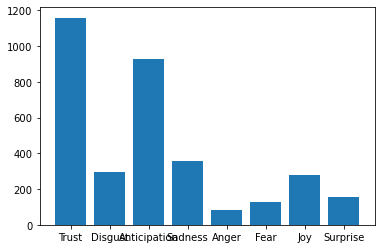

In [23]:
# Visualizing label distribution
plt.bar(counter_2.keys(), counter_2.values())
plt.show()

In [24]:
df_2["text_clean"] = df_2["discussion_text"].apply(lambda x: preprocess(x))
df_2.tail(6)["text_clean"]

1420    i am do thi for myself and to help my health y...
1421    i am extrem glad i found thi forum and all you...
1422    i am fairli newli diagnos with type diabet whi...
1423    i am fairli newli diagnos with type diabet whi...
1424    i am go through the same thing right now i had...
1425    i am go to ask my doctor for a fast insulin te...
Name: text_clean, dtype: object

In [25]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_2.text_clean, df_2.Label,
                                                                        test_size = 0.2,
                                                                        random_state = 42,
                                                                        shuffle = True,
                                                                        stratify = df_2.Label)
print(Counter(y_train_2))
print(Counter(y_test_2))

Counter({'Living with diabetes - Nutrition': 335, 'Living with diabetes - Lifestyle; Social and Psychological': 231, 'Clinical Treatment': 177, 'Undiagnosed': 150, 'Living with diabetes - Exercise': 148, 'Diagnosis ': 47, 'Relatives of diabetes patients': 41, 'Alternative Treatment': 11})
Counter({'Living with diabetes - Nutrition': 84, 'Living with diabetes - Lifestyle; Social and Psychological': 58, 'Clinical Treatment': 45, 'Undiagnosed': 37, 'Living with diabetes - Exercise': 37, 'Diagnosis ': 12, 'Relatives of diabetes patients': 10, 'Alternative Treatment': 3})


In [26]:
patientJourney_log_clf = logistic_model.fit(X_train_2, y_train_2)
patientJourney_log_pred = logistic_model.predict(X_test_2)

patientJourney_MNB_clf = MNB_model.fit(X_train_2, y_train_2)
patientJourney_MNB_pred = MNB_model.predict(X_test_2)

In [27]:
patientJourney_log_acc = accuracy_score(y_test_2, patientJourney_log_pred)
patientJourney_MNB_acc = accuracy_score(y_test_2, patientJourney_MNB_pred)

print('Accuracy for logistic model:', patientJourney_log_acc)
print('Accuracy for MNB model:', patientJourney_MNB_acc)

Accuracy for logistic model: 0.458041958041958
Accuracy for MNB model: 0.2972027972027972


In [28]:
patientJourney_logistic_report = metrics.classification_report(y_test_2, 
                                                         patientJourney_log_pred, 
                                                         target_names = labels_2)

patientJourney_MNB_report = metrics.classification_report(y_test_2, 
                                                    patientJourney_MNB_pred, 
                                                    target_names = labels_2)

print('Classification report for logistic model:\n', patientJourney_logistic_report)
print('Classification report for MNB model:\n', patientJourney_MNB_report)

Classification report for logistic model:
                                                             precision    recall  f1-score   support

                          Living with diabetes - Nutrition       0.00      0.00      0.00         3
                                               Undiagnosed       0.54      0.49      0.51        45
                                        Clinical Treatment       0.00      0.00      0.00        12
                            Relatives of diabetes patients       0.53      0.27      0.36        37
Living with diabetes - Lifestyle; Social and Psychological       0.38      0.31      0.34        58
                           Living with diabetes - Exercise       0.46      0.89      0.60        84
                                     Alternative Treatment       0.00      0.00      0.00        10
                                                Diagnosis        0.43      0.16      0.24        37

                                                  accur

C:\Users\Saim\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Saim\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Saim\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Saim\anaconda3\lib\site-packages\sklearn\metrics\

The low accuracy scores can be attributed to the fact that even though we accounted for the class imbalance through ADASYN, the algorithm does not perform well on sparse matrices, which our dataset becomes after vectorization, as vizualised below for the emotions dataset. The solution to this is to perform feature selection and then pass the data to the models.

Text(0.5, 1.0, 'Word Matrix')

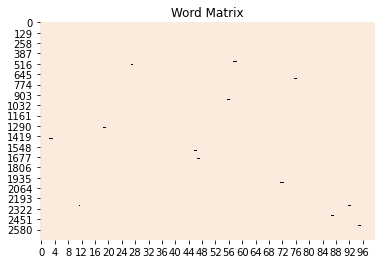

In [33]:
# Feature matrix has a shape of 2708 documents (number of rows in splitted df) and 10k features
# Converting Series object to equivalent pipeline vectors in order to visualize. 
vectorizer = TfidfVectorizer(stop_words = "english",
                             ngram_range = (1, 4))

X_viz = vectorizer.fit_transform(X_train)

    
sns.heatmap(X_viz.todense()[:,np.random.randint(0, 
                                X_viz.shape[1], 
                                100)]==0, 
                                vmin=0, 
                                vmax=1, 
                                cbar=False).set_title('Word Matrix')

In [118]:
test = SelectKBest(score_func=chi2, k=4)

fit = test.fit(X_train, y_train)
fit.scores_

array([15.51148814, 15.51148814,  5.12242753, ...,  9.69732705,
       12.8900929 ,  6.37222074])

In [121]:
X_new=test.fit_transform(X_train, y_train)
print(X_new)

  (118, 0)	1
  (118, 1)	1
  (293, 3)	4
  (857, 1)	2
  (1044, 1)	1
  (1117, 2)	5
  (1136, 3)	1
  (1446, 1)	1
  (1484, 0)	4
  (1484, 1)	4
  (1627, 3)	1
  (2118, 2)	5
  (2156, 1)	2


In [ ]:
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)